### cnn을 이용해서 패치의 평균 값을 예측

In [1]:
import os
import torch
from torchvision import transforms
from utils.utils import train_model, TiffDataset, DualTransform, process_large_image, visualize_result, he_init_weights
from models.cnn import CNNRegressor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import rasterio
import gc

In [2]:
large_tif_dir = "../../data/source_data/with_s2/"  # 원천 데이터 TIFF 파일이 있는 폴더
file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"]  # 사용할 TIFF 파일 리스트
checkpoints_dir = "./checkpoints/use_patch" #check point 저장할 폴더
os.makedirs(checkpoints_dir, exist_ok=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 데이터 전처리 방법 설정

In [4]:
source_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환 -> squeeze
])

label_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float().mean(dim=[1, 2], keepdim=False))  # 평균 계산 후 (1,) 유지
])

# DualTransform을 적용하여 입력과 레이블을 변환
dual_transform = DualTransform(source_transform, label_transform)

### test 지역 선별 방법

In [5]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5) #test지역 선별

## target: height

In [6]:
# 데이터 경로 설정
target = "height"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [7]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [8]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저 (Adam 추천)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
num_epochs = 100

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)

torch.save(best_model_state, os.path.join(checkpoints_dir, f"cnn_{target}_{patch_size}_{num_epochs}.pth"))

Epoch 1/1 - Training:   0%|          | 0/26325 [00:00<?, ?it/s]

Epoch 1/1 - Validation: 100%|██████████| 7425/7425 [00:21<00:00, 341.26it/s]



Epoch [1/1], Train Loss: 12.4073, Train R² Score: 0.5016, Val Loss: 14.6844, Val R² Score: 0.3847



In [10]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

 35%|███▍      | 346141/1000000 [07:37<14:24, 756.60it/s]


KeyboardInterrupt: 

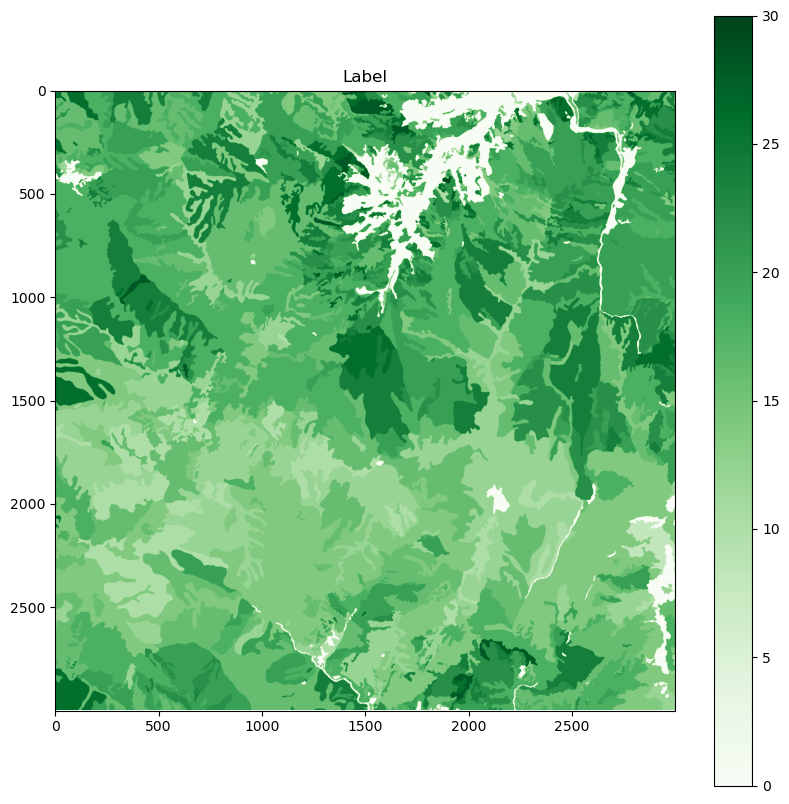

In [ ]:
with rasterio.open("../../data/label_data/height/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

In [ ]:
del model, train_loader, val_loader, train_dataset, val_dataset, criterion, optimizer
torch.cuda.empty_cache()  # GPU 캐시 정리
gc.collect()  # Python 가비지 컬렉터 실행

NameError: name 'model' is not defined

## target: density

In [ ]:
target = "density"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [ ]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 100

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)

torch.save(best_model_state, os.path.join(checkpoints_dir, f"cnn_{target}_{patch_size}_{num_epochs}.pth"))

Epoch 1/1 - Validation: 100%|██████████| 7425/7425 [00:17<00:00, 429.29it/s]


Epoch [1/1], Train Loss: 0.3009, Train R² Score: -11.3079, Val Loss: 0.0161, Val R² Score: -0.0295



100%|██████████| 1000000/1000000 [08:44<00:00, 1906.85it/s]


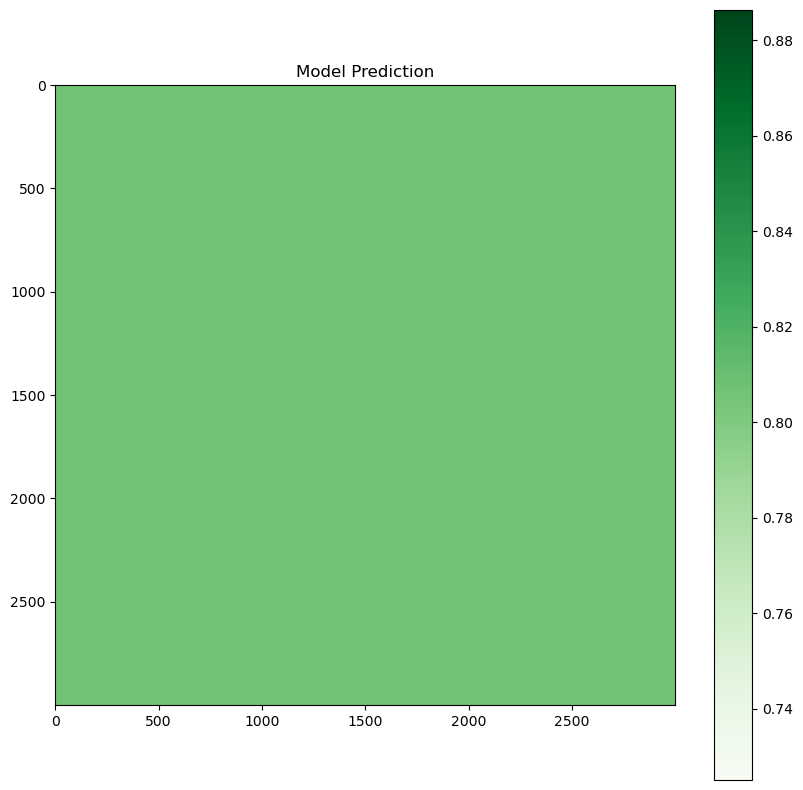

In [ ]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

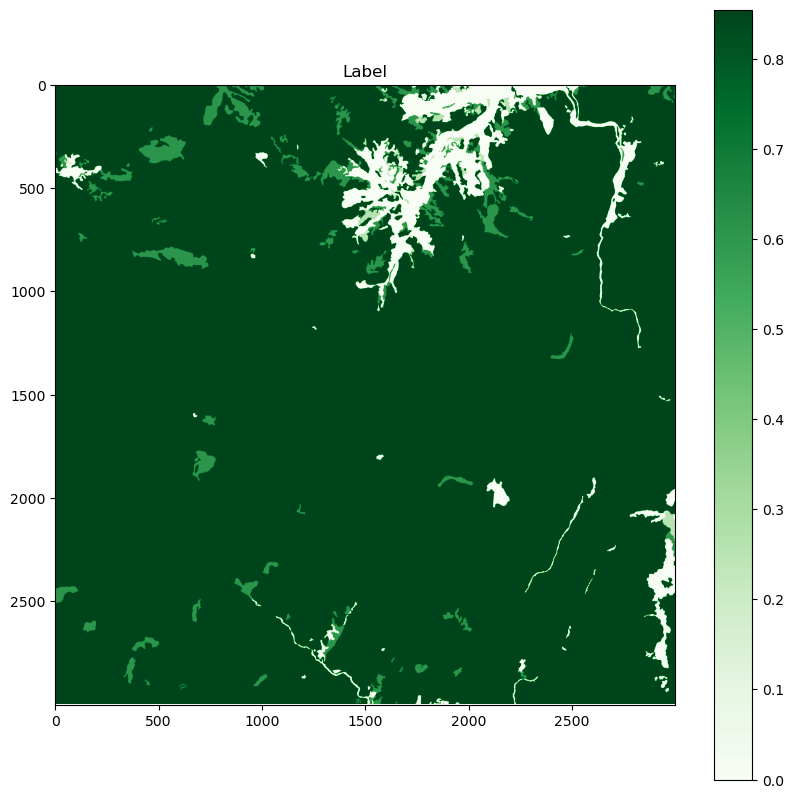

In [ ]:
with rasterio.open("../../data/label_data/density/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

In [ ]:
del model, train_loader, val_loader, train_dataset, val_dataset, criterion, optimizer
torch.cuda.empty_cache()  # GPU 캐시 정리
gc.collect()  # Python 가비지 컬렉터 실행

11051

### target: DBH

In [ ]:
target = "DBH"
label_dir = f"../../data/label_data/{target}"  # 대응하는 레이블 TIFF 파일이 있는 폴더

In [ ]:
patch_size = 5
stride = 5

# 데이터셋 생성
train_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=lambda box_number: not test_filter(box_number), transform=dual_transform)
val_dataset = TiffDataset(large_tif_dir, label_dir, file_list, patch_size=patch_size, stride=stride, box_filter_fn=test_filter, transform=dual_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
model = CNNRegressor().to(device)
model.apply(he_init_weights)

# 손실 함수
criterion = nn.MSELoss()  # 평균제곱오차 손실

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 100

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100, task_type = "r"
)
model.load_state_dict(best_model_state)


Epoch 1/1 - Validation: 100%|██████████| 7425/7425 [00:17<00:00, 426.50it/s]



Epoch [1/1], Train Loss: 19.5839, Train R² Score: 0.3451, Val Loss: 19.8905, Val R² Score: 0.2052



<All keys matched successfully>

100%|██████████| 1000000/1000000 [08:44<00:00, 1905.86it/s]


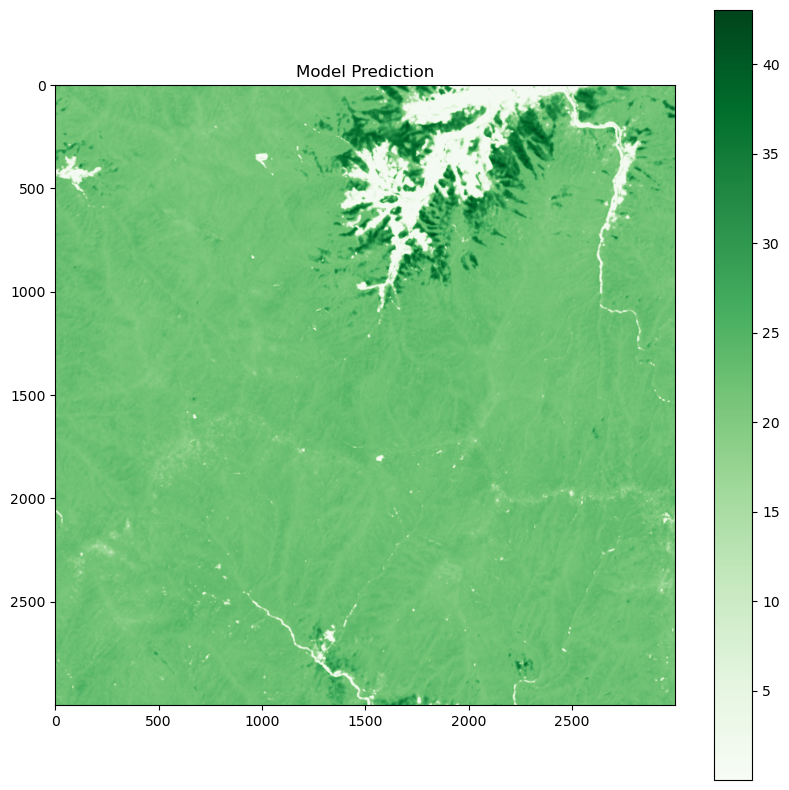

In [ ]:
result = process_large_image(model, "../../data/source_data/with_s2/jiri_1.tif", patch_size=patch_size, stride=3)
visualize_result(result, "Model Prediction")

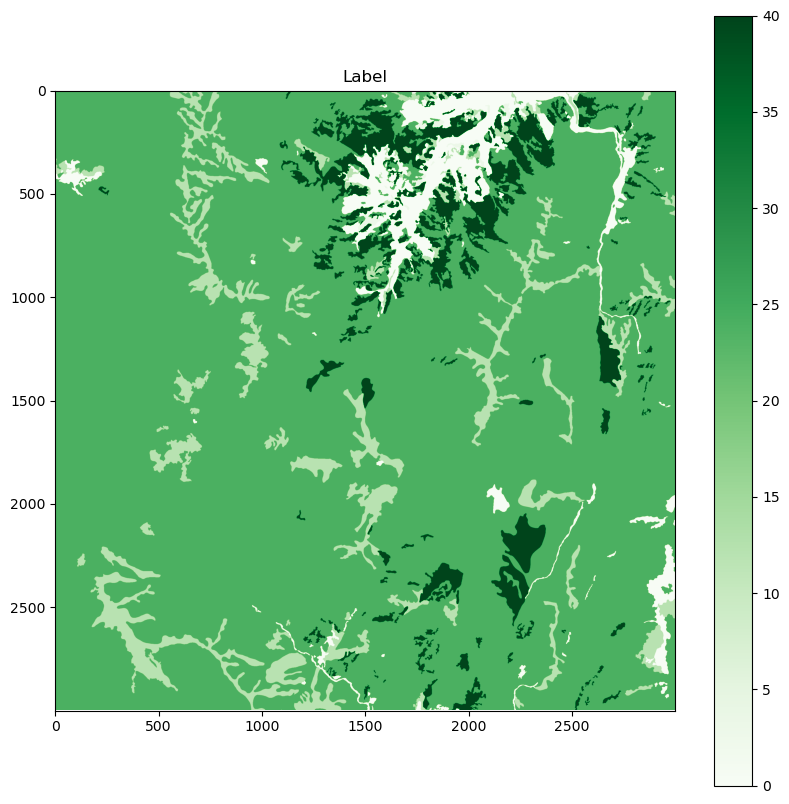

In [ ]:
with rasterio.open("../../data/label_data/DBH/jiri_1.tif") as src:
    image = src.read()
visualize_result(image, "Label") 

======================================================================================================================================